In [48]:
import random
import numpy as np
import matplotlib.pyplot as plt
import progressbar
random.seed(2019)

In [60]:
# sampling parameters
nballs = 15
nbins = 50
nshuffles = 100000

In [50]:
# initialize stars and bars list that we will repeatedly shuffle
BALL = 0
SEP = 1

shuffle_me = [BALL for _ in range(nballs)] + \
             [SEP for _ in range(nbins - 1)]

In [51]:
# as we shuffle, we want to keep track of a histogram counting how many
# times we saw x balls in the first bin. the histogram should track
# anywhere from zero balls to all N balls in the bin
occupancy_hist = [0 for _ in range(nballs + 1)]

In [52]:
# a function that takes a particular configuration of the balls and 
# separators and updates the occupancy histogram
def get_occupancy_map(config, nbins):
    # initialize variables
    occ_map = {k:0 for k in range(nbins)}
    counter = 0
    bin_idx = 0
    
    # go through the whole configuration
    for elem in config:
        # if we see a ball, update the counter for this bin
        if elem == BALL:
            counter += 1
        # if we see a separator, set the occupancy for the bin to the
        # counter, and then move to the next bin, resetting the counter
        elif elem == SEP:
            occ_map[bin_idx] = counter
            bin_idx += 1
            counter = 0
            
    return occ_map

# a function that takes an occupancy map and updates a counts histogram
def update_hist(hist, occ_map):
    for _, v in occ_map.items():
        hist[v] += 1

In [61]:
# sample a bunch of shuffles and update counts histogram
pbar = progressbar.ProgressBar()

for shuf in pbar(range(nshuffles)):
    random.shuffle(shuffle_me)
    occ_map = get_occupancy_map(shuffle_me, nbins)
    update_hist(occupancy_hist, occ_map)
    pbar.update(shuf)

pbar.finish()

# compute the empirically-sampled normalized probability
counts_float = np.array(occupancy_hist, dtype='float64')
normalized_counts = counts_float / counts_float.sum()
log_empirical_histo = np.log(normalized_counts)

100% |########################################################################|
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [54]:
# compute the boltzmann solution and the analytical solution
def log_boltzmann(x, nballs, nbins):
    beta = np.log(1 + nbins / nballs)
    return -beta * x

def log_analytical_solution(x, nballs, nbins):
    beta_x = np.log(1 + (nbins - 2) / (nballs - x))
    no_offset = (nballs - x) * beta_x + \
                    (nbins - 2) * np.log(nballs + nbins - 2 - x)
    return no_offset - np.nanmax(no_offset)

In [55]:
# function to make a plot with all the results
def make_plot(x, emp_histo, nballs, nbins):
    plt.figure(figsize=(10, 6))
    plt.plot(x, emp_histo, 'bo-', label='Naive Sampling')
    plt.plot(x, log_boltzmann(x, nballs, nbins), 'k--', label='Boltzmann')
    plt.plot(x, log_analytical_solution(x, nballs, nbins), 'r.-', 
             label='Analytical')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\log P(n_1 = x)$')
    plt.legend()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


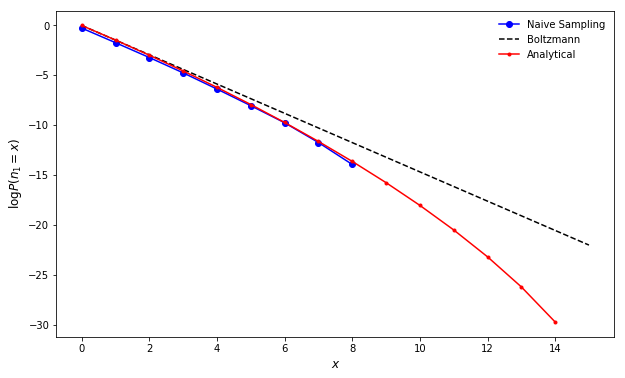

In [62]:
# actually make the plot
x = np.array(list(range(nballs+1)), dtype='float64')
make_plot(x, log_empirical_histo, nballs, nbins)

In [63]:
def update_histogram(occ_map, h, weight):
    for _, v in occ_map.items():
        h['weighted_counts'][v] += weight
        h['sum_weights'] += weight

In [64]:
def compute_importance_sampling_weight(N, M, k):
    log_weight = (N + M - k) * np.log(N + M - k) + \
                    N * np.log(N) - (N - k) * np.log(N - k) - \
                    (N + M) * np.log(N + M)
    return log_weight

def compute_importance_sampling_weight2(N, M, k):
    log_weight = 1 + N * np.log(N) + \
        (k - N)*np.log(-k + N) - \
        (-1 + M + N) *np.log(-1 + M + N) + \
        (-2 - k + M + N) * np.log(-2 - k + M + N)
    return log_weight

In [68]:
# now try importance sampling to get better convergence
nshuffles_per_k = np.ceil(np.power(np.arange(nballs) + 1, 2) * 100)
total_shuffles = nshuffles_per_k.sum()
done_shuffles = 0

pbar = progressbar.ProgressBar(total_shuffles)
pbar.start()

# initialize a histogram
histogram = {'weighted_counts': np.zeros(nballs + 1), 'sum_weights': 0.0}

for k, nshuf in zip(range(nballs), nshuffles_per_k):
    log_weight = compute_importance_sampling_weight2(nballs, nbins-1, k)
    shuffle_me = [BALL for _ in range(nballs - k)] + \
                    [SEP for _ in range(nbins - 1)]
    
    for shuf in range(int(nshuf)):
        random.shuffle(shuffle_me)
        occ_map = get_occupancy_map([BALL for _ in range(k)] + shuffle_me, 
                                    nbins)
        update_histogram(occ_map, histogram, np.exp(log_weight))
        done_shuffles += 1
        pbar.update(done_shuffles)
        
pbar.finish()
        
importance_histo = histogram['weighted_counts'] / histogram['sum_weights']
log_importance_histo = np.log(importance_histo)
log_importance_histo -= np.nanmax(log_importance_histo)

100% |########################################################################|


In [66]:
# function to make a plot with all the results
def make_plot_with_importance(x, emp_histo, imp_histo, nballs, nbins):
    plt.figure(figsize=(10, 6))
    plt.plot(x, emp_histo, 'bo-', label='Naive Sampling')
    plt.plot(x, imp_histo, 'go-', label='Importance Sampling')
    plt.plot(x, log_boltzmann(x, nballs, nbins), 'k--', label='Boltzmann')
    plt.plot(x, log_analytical_solution(x, nballs, nbins), 'r.-', 
             label='Analytical')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\log P(n_1 = x)$')
    plt.legend()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


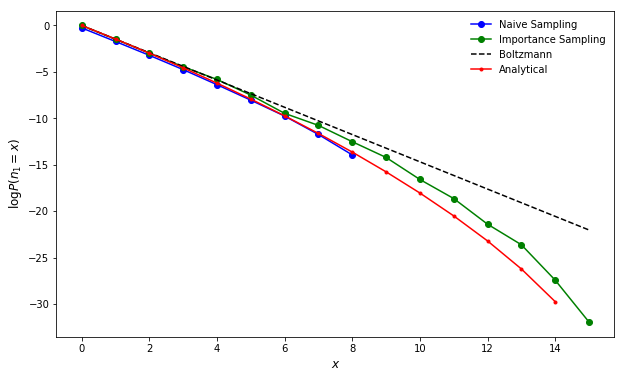

In [69]:
# actually make the plot
x = np.array(list(range(nballs+1)), dtype='float64')
make_plot_with_importance(x, log_empirical_histo, log_importance_histo, 
                          nballs, nbins)